# 3.1 Data Processing
In this exercise we will build a complete EO workflow on a cloud platform; from data access to obtaining the result. 
In this example we will analyse snow cover in the Alps. 
**MORE DETAILS HERE**: This exercise should be more repetition, and the goal is that everybody arrives at the result - without coding very much themselves. Then the transfer application will be done in the sharing exercise

We are going to follow these steps in our analysis:
- Load relevant data sources
- Specify the spatial, temporal extents and the features we are interested in
- Process the satellite data to retreive snow cover information
- aggregate information in data cubes
- Tracking the resources we use for our computation
- Visualize and analyse the results


## Login

In [1]:
pip install rioxarray geopandas leafmap

Note: you may need to restart the kernel to use updated packages.


In [1]:
# platform libraries
import openeo

# utility libraries
from datetime import date
import numpy as np
import xarray as xr
import rioxarray
import json
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import leafmap.foliumap as leafmap

In [2]:
conn = openeo.connect('https://openeo.dataspace.copernicus.eu/').authenticate_oidc()

Authenticated using refresh token.


## Region of Interest

Load the catchment area.

In [3]:
catchment_outline = gpd.read_file('data/catchment_outline.geojson')

In [4]:
center = (float(catchment_outline.centroid.y), float(catchment_outline.centroid.x))
m = leafmap.Map(center=center, zoom=10)
m.add_vector('data/catchment_outline.geojson', layer_name="catchment")
m

## Inspect Metadata
We need to set the following configurations to define the content of the data cube we want to access:
- dataset name
- band names
- time range
- the area of interest specifed via bounding box coordinates
- spatial resolution

To select the correct dataset we can first list all the available datasets.

In [5]:
print(conn.list_collection_ids())

['SENTINEL3_OLCI_L1B', 'SENTINEL3_SLSTR', 'SENTINEL_5P_L2', 'SENTINEL2_L1C', 'SENTINEL2_L2A', 'SENTINEL1_GRD', 'COPERNICUS_30']


We want to use the Sentinel-2 L2A product. It's name is `'SENTINEL2_L2A'`. 

We get the metadata for this collection as follows.

In [6]:
conn.describe_collection("SENTINEL2_L2A")

{'assets': {'thumbnail': {'href': 'https://www.esa.int/var/esa/storage/images/esa_multimedia/images/2022/07/tallinn_estonia/24383281-1-eng-GB/Tallinn_Estonia_pillars.jpg',
   'roles': ['thumbnail'],
   'title': 'Sentinel 2 L2A',
   'type': 'image/png'}},
 'cube:dimensions': {'bands': {'type': 'bands',
   'values': ['B01',
    'B02',
    'B03',
    'B04',
    'B05',
    'B06',
    'B07',
    'B08',
    'B8A',
    'B09',
    'B11',
    'B12',
    'WVP',
    'AOT',
    'SCL',
    'sunAzimuthAngles',
    'sunZenithAngles',
    'viewAzimuthMean',
    'viewZenithMean']},
  't': {'extent': ['2015-07-04T00:00:00Z', None], 'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-180, 180],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [-56, 83],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'}},
 'description': 'SENTINEL-2 is a wide-swath, high-resolution, multi-spectral imaging mission, supporting Copernicus Land Monitoring studies, including the monitoring of vegetation, soil and water cover, as well as observation of inland waterways and coastal areas. The SENTINEL-2 Multispectral Instrument (MSI) samples 13 spectral bands: four bands at 10 metres, six bands at 20 metres and three bands at 60 metres spatial resolution.\n The level 2A data is atmospherically corrected using Sen2Cor.',
 'extent': {'spatial': {'bbox': [[-180, -56, 180, 83]]},
  'temporal': {'interval': [['2015-07-04T00:00:00Z', None]]}},
 'id': 'SENTINEL2_L2A',
 'keywords': ['COPERNICUS',
  'ESA',
  'Orthoimagery',
  'Sentinel-2',
  'MSI',
  'Level-2A',
  'Radiometry',
  'Plant Resource',
  'TOC'],
 'license': 'proprietary',
 'links': [{'href': 'https://sentinels.copernicus.eu/documents/247904/690755/Sentinel_Data_Legal_Notice',
   'rel': 'license',
   'type': 'application/pdf'},
  {'href': 'https://documentation.dataspace.copernicus.eu/Data/Sentinel2.html',
   'rel': 'alternate',
   'type': 'application/html'},
  {'href': 'https://dataspace.copernicus.eu/browser/?zoom=11&lat=45.36638&lng=12.49832&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fsh.dataspace.copernicus.eu%2Fogc%2Fwms%2F28b654e7-8912-4e59-9e58-85b58d768b3a&datasetId=S2_L2A_CDAS&fromTime=2023-02-07T00%3A00%3A00.000Z&toTime=

## Define a workflow
We will define our workflow now. And chain all the processes together we need for analyzing the snow cover in the catchment.

### Define the data cube
We define all extents of our data cube. We use the catchment as spatial extent. As a time range we will focus on the snow melting season 2018, in particular from Febraury to June 2018.

In [7]:
bbox = catchment_outline.bounds.iloc[0]
bbox

minx    11.020833
miny    46.653599
maxx    11.366667
maxy    46.954167
Name: 0, dtype: float64

In [8]:
collection      = 'SENTINEL2_L2A'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':4326}
temporal_extent = ["2018-02-01", "2018-06-30"]
bands           = ['B03', 'B11', 'SCL']

### Load the data cube
We have defined the extents we are interested in. Now we use these definitions to load the data cube.

In [9]:
s2 = conn.load_collection(collection,
                          spatial_extent=spatial_extent, # put json here
                          bands=bands,
                          temporal_extent=temporal_extent)
s2

### NDSI - Normalized Difference Snow Index
The Normalized Difference Snow Index (NDSI) is computed as:

$$ NDSI = \frac {GREEN - SWIR} {GREEN +SWIR} $$

We have created a Sentinel-2 data cube with bands B03 (green), B11 (SWIR) and the cloud mask (CLM). We will use the green and SWIR band to calculate a the NDSI. This process is reducing the band dimension of the data cube to generate new information, the NDSI.

In [10]:
green = s2.band("B03")
swir = s2.band("B11")
ndsi = (green - swir) / (green + swir)
ndsi

### Creating the Snow Map
So far we have a timeseries of NDSI values. We are intereseted in the presence of snow though. Ideally in a binary classification: snow and no snow.
To achieve this we are setting a threshold of 0.4 on the NDSI. This gives us a binary snow map.

In [11]:
snowmap = ( ndsi > 0.4 ) * 1.0
snowmap

### Creating a cloud mask
We are going to use "SCL" band for creating a cloud mask and then applying it to the NDSI. Here is more information on the Scene Classification https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm-overview

| Value        | Label    |
|--------------|-----------|
| 0	    | NO_DATA                  |
| 1	    | SATURATED_OR_DEFECTIVE   |
| 2	    | CAST_SHADOWS             |
| 3	    | CLOUD_SHADOWS            |
| 4	    | VEGETATION               |
| 5	    | NOT_VEGETATED            |
| 6	    | WATER 	    	       |
| 7	    | UNCLASSIFIED 	           |
| 8	    | CLOUD_MEDIUM_PROBABILITY |
| 9	    | CLOUD_HIGH_PROBABILITY   |
| 10	| THIN_CIRRUS              |
| 11	| SNOW or ICE              |SNOW or ICE

In [12]:
scl_band = s2.band("SCL")
cloud_mask = ( (scl_band == 8) | (scl_band == 9) | (scl_band == 3) ) * 1.0
cloud_mask

### Applying the cloud mask to the snowmap
We will mask out all pixels that are covered by clouds. This will result in: 0 = no_snow, 1 = snow, NA = cloud

In [13]:
snowmap_cloudfree = snowmap.mask(cloud_mask,replacement=2) # replacement is null by default
snowmap_cloudfree

### Filter Spatial: From Bounding Box to Shape

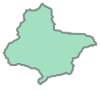

In [14]:
catchment_outline['geometry'][0]

In [15]:
# filter to the exact outline of the catchment: this should mask out the pixels outside of the catchment. The process are doing this not correctly. They base the masking on chunks.
snowmap_cloudfree_masked = snowmap_cloudfree.mask_polygon(catchment_outline['geometry'][0])

### Visualize some time steps of the timeseries
Let's donwload the whole image time series as a netcdf file to have a look how our first results look like

In [ ]:
snowmap_cloudfree_1d = snowmap_cloudfree_masked.filter_temporal('2018-02-10', '2018-02-12')
# snowmap_cloudfree_1d = snowmap_cloudfree_masked.filter_temporal('2018-02-25', '2018-02-27')

snowmap_cloudfree_1d.download('data/snowmap_cloudfree_1d.nc')

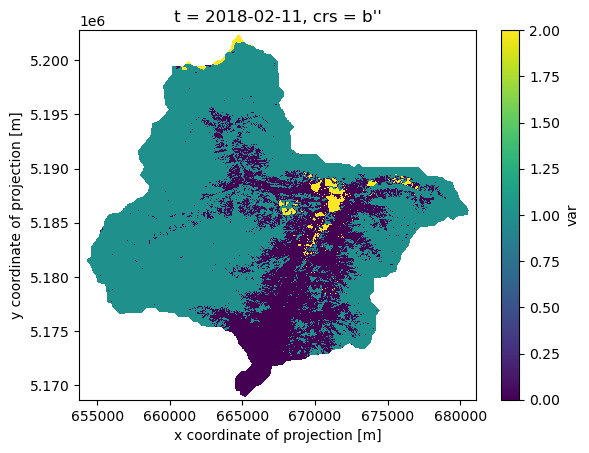

In [18]:
xr.open_dataarray('data/snowmap_cloudfree_1d.nc',decode_coords="all")[0].plot.imshow()

### Cloud Percentage
We are looking at a region over time. We need to make sure that the information content meets our expected quality. Therefore, we calculate the cloud percentage for the catchment for each timestep. We use this information to filter the timeseries. All timesteps that have a cloud coverage of over 20% will be discarded.

In [17]:
# get number of all pixels in catchment
# get number of cloud pixels in catchment
n_catchment = ((snowmap_cloudfree_masked > -1) * 1.0).add_dimension(name="bands",type="bands",label="n_catchment")

n_cloud = cloud_mask.add_dimension(name="bands",type="bands",label="n_cloud")

n_catchment_cloud = n_catchment.merge_cubes(n_cloud).mask_polygon(catchment_outline['geometry'][0])

n_pixels = n_catchment_cloud.aggregate_spatial(geometries = catchment_outline['geometry'][0], reducer = 'sum')

In [ ]:
# Create a batch job
n_pixels_json = n_pixels.save_result(format="JSON")
job = n_pixels_json.create_job(title="n_pixels_json")
job.start_job()

In [24]:
job

<BatchJob job_id='j-de0da2972c7449c0a42b843ab04abc30'>

In [25]:
results = job.get_results()
results.download_files("data")

[WindowsPath('data/timeseries.json'), WindowsPath('data/job-results.json')]

In [19]:
# load number of valid and clouded pixels per time step
with open("data/timeseries.json","r") as file:
    n_pixels_json = json.load(file)

In [20]:
# check the first 5 entries
list(n_pixels_json.items())[:5]

[('2018-02-21T00:00:00Z', [[4201607.0, 4697.0]]),
 ('2018-02-18T00:00:00Z', [[4201607.0, 852050.0]]),
 ('2018-04-27T00:00:00Z', [[4201607.0, 4086401.0]]),
 ('2018-04-29T00:00:00Z', [[4201607.0, 4187923.0]]),
 ('2018-05-22T00:00:00Z', [[4201607.0, 4201607.0]])]

In [78]:
# get the values out of the dictionary
dates = [k for k in n_pixels_json]
n_catchment_vals = [n_pixels_json[k][0][0] for k in n_pixels_json]
n_cloud_vals = [n_pixels_json[k][0][1] for k in n_pixels_json]

In [79]:
data = {
        "time":pd.to_datetime(dates),
        "n_catchment_vals":n_catchment_vals,
        "n_cloud_vals":n_cloud_vals
       }
df = pd.DataFrame(data=data).set_index("time")
df = df.sort_values(axis=0,by="time")
df[:5]

,n_catchment_vals,n_cloud_vals
time,,
2018-02-01 00:00:00+00:00,4201607.0,4196050.0
2018-02-03 00:00:00+00:00,4201607.0,3921067.0
2018-02-06 00:00:00+00:00,4201607.0,2575183.0
2018-02-08 00:00:00+00:00,4201607.0,183099.0
2018-02-11 00:00:00+00:00,4201607.0,67041.0


In [80]:
# divide the number of cloudy pixels by the number of total pixels = cloud percentage
perc_cloud = df["n_cloud_vals"].values / df["n_catchment_vals"].values * 100
df["perc_cloud"] = perc_cloud
df[:5]

,n_catchment_vals,n_cloud_vals,perc_cloud
time,,,
2018-02-01 00:00:00+00:00,4201607.0,4196050.0,99.867741
2018-02-03 00:00:00+00:00,4201607.0,3921067.0,93.323031
2018-02-06 00:00:00+00:00,4201607.0,2575183.0,61.290430
2018-02-08 00:00:00+00:00,4201607.0,183099.0,4.357833
2018-02-11 00:00:00+00:00,4201607.0,67041.0,1.595604


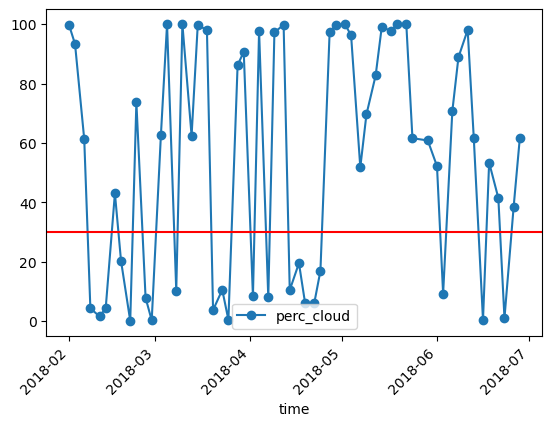

In [81]:
# plot the cloud percentage and a threshold
df.plot(y="perc_cloud",rot=45,kind="line",marker='o')
plt.axhline(y = 30, color = "r", linestyle = "-")
plt.show()

### Snow Covered Area in the Catchment
We are interested in the snow covered area (SCA) within the catchment. We count all snow covered pixels within the catchment for each time step. After our snow classification our data cube has the values: 0 = no snow, 1 = snow, NA = cloud. This means we can sum up all pixels within the catchment and the sum will give us the count of the snow covered pixels. Later we can use this number to translate pixel count into area.

In [ ]:
# get number of snow pixels in catchment
n_snow = ((snowmap_cloudfree_masked == 1) * 1.0).aggregate_spatial(geometries = catchment_outline['geometry'][0], reducer = 'sum')
# Create a batch job
n_snow_json = n_snow.save_result(format="JSON")
job = n_snow_json.create_job(title="n_snow_json")
job.start_job()

In [59]:
if job.status() == "finished":
    results = job.get_results()
    results.download_files("n_snow_json")

In [84]:
# load number of snow pixels per time step
with open("n_snow_json/timeseries.json","r") as file:
    n_snow_json = json.load(file)
list(n_snow_json.items())[:5]

[('2018-02-16T00:00:00Z', [[1479720.0]]),
 ('2018-02-26T00:00:00Z', [[2774517.0]]),
 ('2018-02-28T00:00:00Z', [[2820445.0]]),
 ('2018-05-14T00:00:00Z', [[25406.0]]),
 ('2018-06-08T00:00:00Z', [[137.0]])]

In [85]:
# get the values out of the dictionary
n_snow_vals = [n_pixels_json[k][0][1] for k in n_snow_json]

In [86]:
data = {
        "time":pd.to_datetime(dates),
        "n_snow_vals":n_snow_vals
       }
df_snow = pd.DataFrame(data=data).set_index("time")
df_snow = df_snow.sort_values(axis=0,by="time")
df["n_snow_vals"] = df_snow["n_snow_vals"]

In [87]:
# divide the number of snow pixels by the number of total pixels = snow percentage
perc_snow = df["n_snow_vals"].values / df["n_catchment_vals"].values * 100
df["perc_snow"] = perc_snow
df[:5]

,n_catchment_vals,n_cloud_vals,perc_cloud,n_snow_vals,perc_snow
time,,,,,
2018-02-01 00:00:00+00:00,4201607.0,4196050.0,99.867741,352770.0,8.396073
2018-02-03 00:00:00+00:00,4201607.0,3921067.0,93.323031,138067.0,3.286052
2018-02-06 00:00:00+00:00,4201607.0,2575183.0,61.290430,4122223.0,98.110628
2018-02-08 00:00:00+00:00,4201607.0,183099.0,4.357833,4104788.0,97.695667
2018-02-11 00:00:00+00:00,4201607.0,67041.0,1.595604,917783.0,21.843618


In [88]:
# Keep only the dates with cloud coverage less than the threshold
df_filtered = df.loc[df["perc_cloud"]<30]

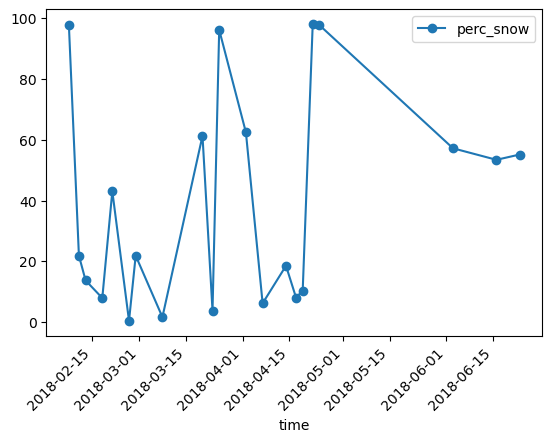

In [89]:
# plot the snow percentage
df_filtered.plot(y="perc_snow",rot=45,kind="line",marker='o')
plt.show()

### Load Discharge Data

In [90]:
# load discharge data 
discharge_ds = pd.read_csv('data/ADO_DSC_ITH1_0025.csv', sep=',', index_col='Time', parse_dates=True)
discharge_ds.head()

,discharge_m3_s
Time,
1994-01-01 01:00:00,4.03
1994-01-02 01:00:00,3.84
1994-01-03 01:00:00,3.74
1994-01-04 01:00:00,3.89
1994-01-05 01:00:00,3.80


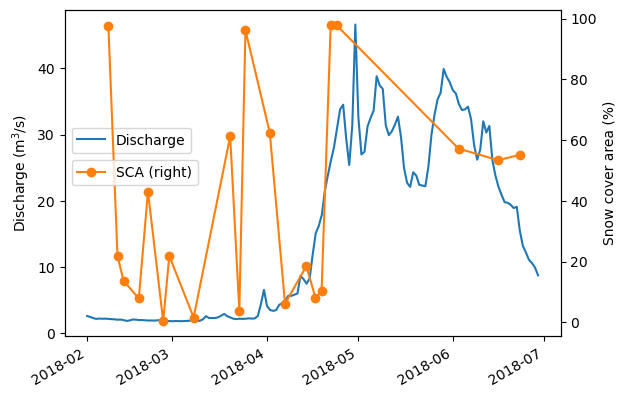

In [93]:
start_date = date(2018, 2, 1)
end_date = date(2018, 6, 30)
# filter discharge data to start and end dates
discharge_ds = discharge_ds.loc[start_date:end_date]

ax1 = discharge_ds.discharge_m3_s.plot(label='Discharge', xlabel='', ylabel='Discharge (m$^3$/s)')
ax2 = df_filtered["perc_snow"].plot(marker='o', secondary_y=True, label='SCA', xlabel='', ylabel='Snow cover area (%)')
ax1.legend(loc='center left', bbox_to_anchor=(0, 0.6))
ax2.legend(loc='center left', bbox_to_anchor=(0, 0.5))
plt.show()